In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
sns.set_palette("viridis")

In [58]:
# --- Load & basic setup ---
df = pd.read_csv("datasets/cleaned/merged_fx_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").set_index("Date")

In [62]:
df.head()

,Buying,Selling,MidRate,MPR,GhInflationRate,BrentOil,Cocoa,Gold,GhInterestRate,GhGDP,USGDP,USInflationRate,USInterestRate
Date,,,,,,,,,,,,,
2008-01-02,0.9545,0.9799,0.9672,13.5,12.81,91.9,2174.5,891.0,12.175,18863.43405,16843.003,87.093,4.11
2008-01-03,0.9545,0.9799,0.9672,13.5,12.81,91.9,2174.5,891.0,12.175,18863.43405,16843.003,87.093,4.25
2008-01-04,0.9543,0.9798,0.9671,13.5,12.81,91.9,2174.5,891.0,12.175,18863.43405,16843.003,87.093,4.18
2008-01-07,0.9551,0.9809,0.9680,13.5,12.81,91.9,2174.5,891.0,12.175,18863.43405,16843.003,87.093,4.27
2008-01-08,0.9576,0.9800,0.9688,13.5,12.81,91.9,2174.5,891.0,12.175,18863.43405,16843.003,87.093,4.27


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4217 entries, 2008-01-02 to 2024-12-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Buying           4217 non-null   float64
 1   Selling          4217 non-null   float64
 2   MidRate          4217 non-null   float64
 3   MPR              4217 non-null   float64
 4   GhInflationRate  4217 non-null   float64
 5   BrentOil         4217 non-null   float64
 6   Cocoa            4217 non-null   float64
 7   Gold             4217 non-null   float64
 8   GhInterestRate   4217 non-null   float64
 9   GhGDP            4217 non-null   float64
 10  USGDP            4217 non-null   float64
 11  USInflationRate  4217 non-null   float64
 12  USInterestRate   4217 non-null   float64
dtypes: float64(13)
memory usage: 461.2 KB


Buying
Skew : 1.43


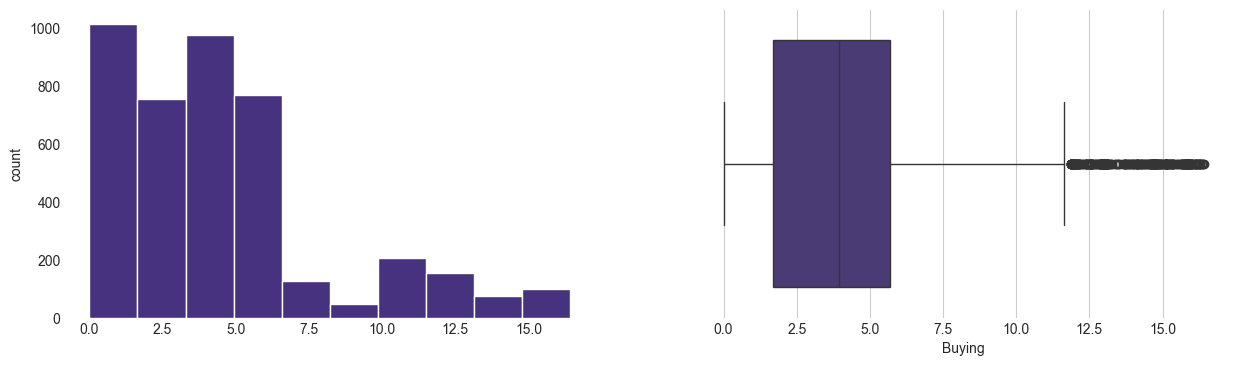

Selling
Skew : 1.43


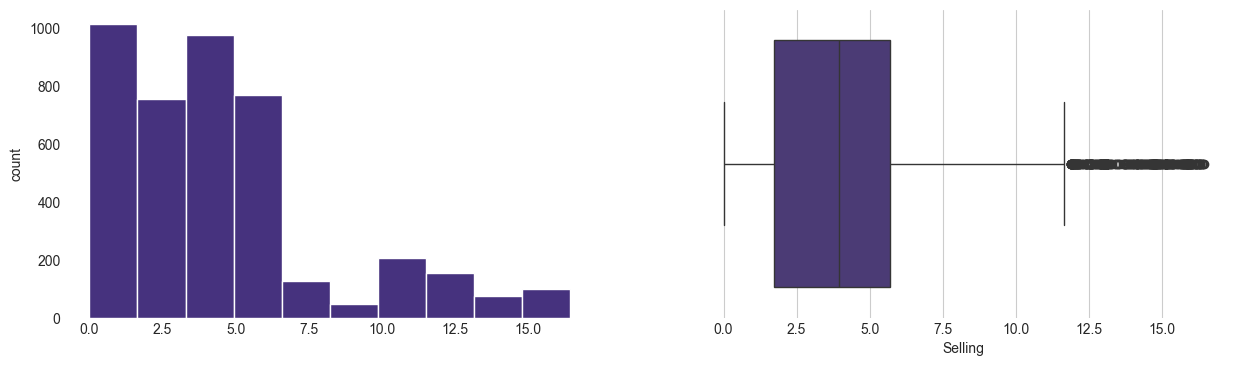

MidRate
Skew : 1.43


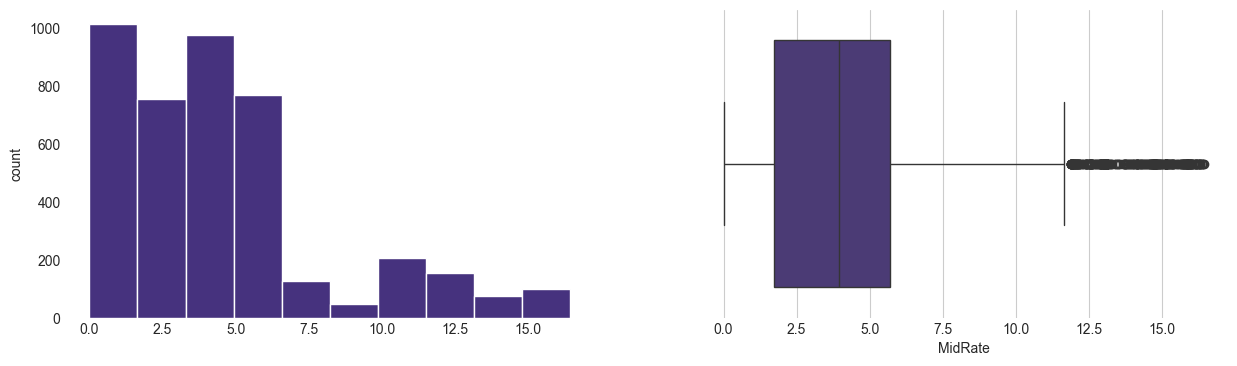

MPR
Skew : 0.81


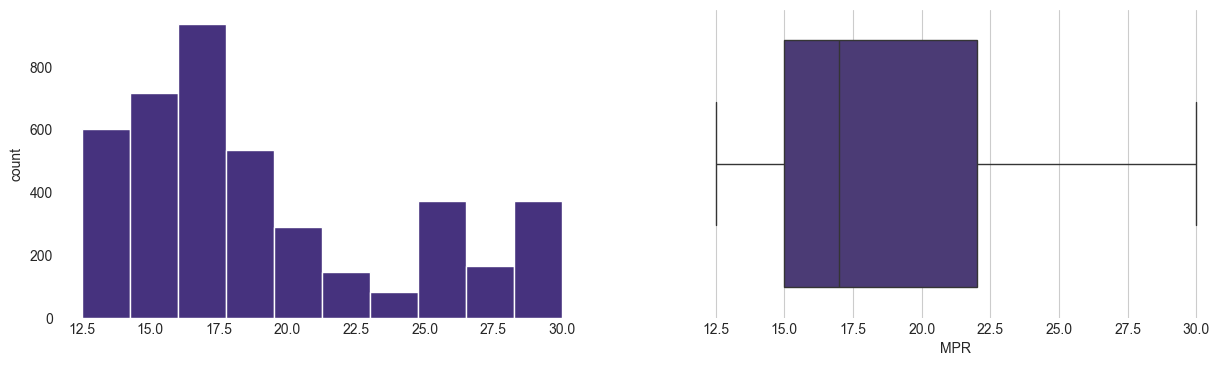

GhInflationRate
Skew : 1.96


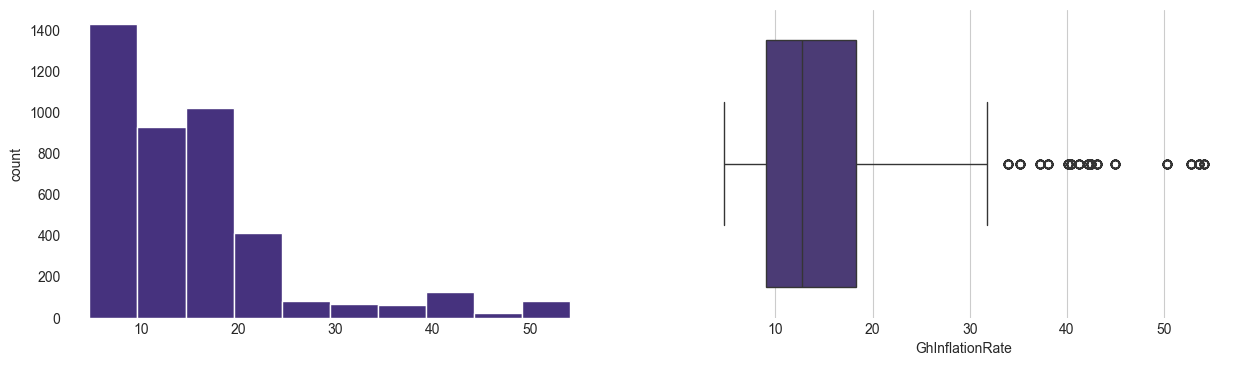

BrentOil
Skew : 0.14


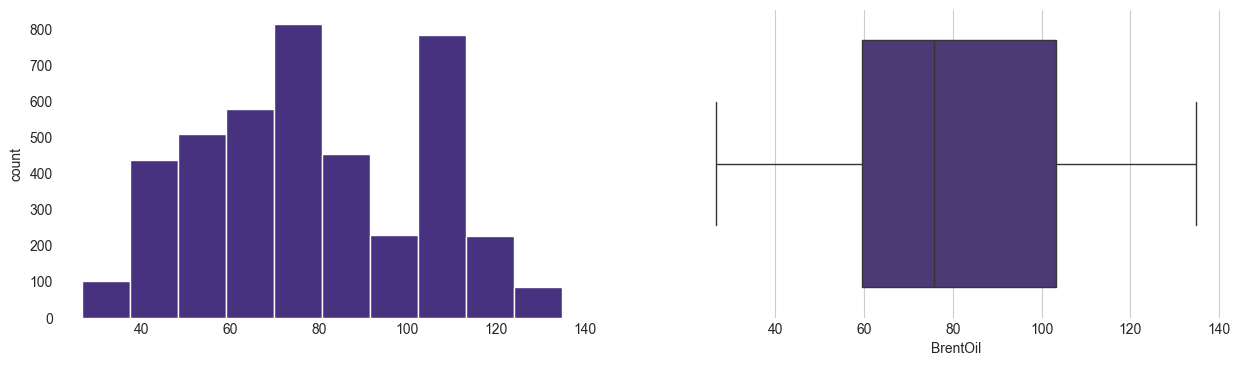

Cocoa
Skew : 10.17


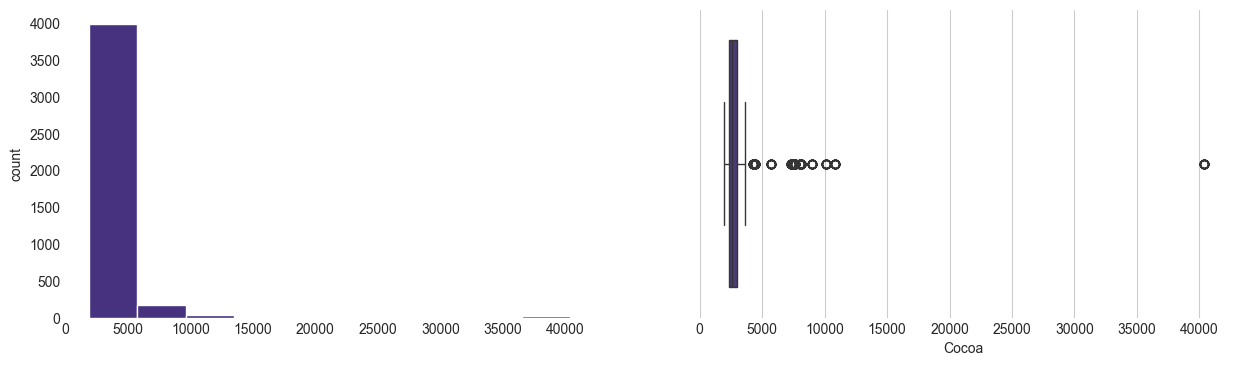

Gold
Skew : 0.7


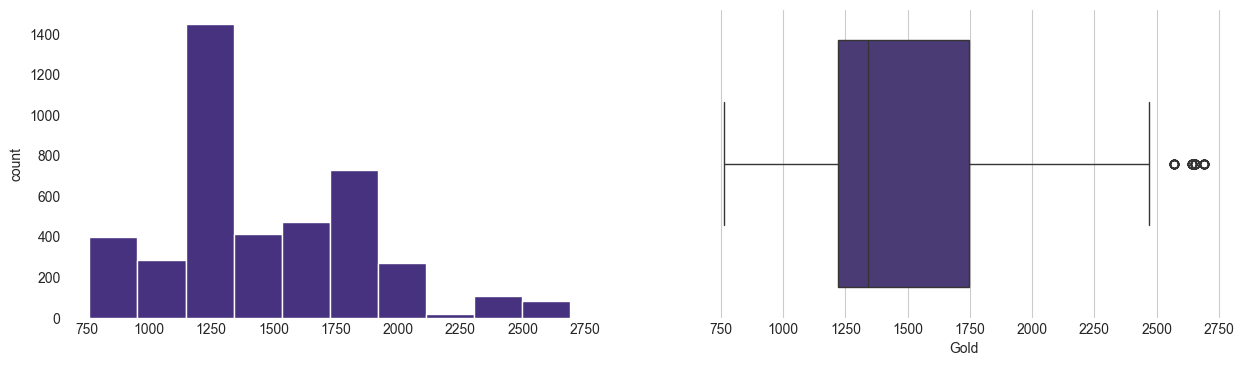

GhInterestRate
Skew : 0.18


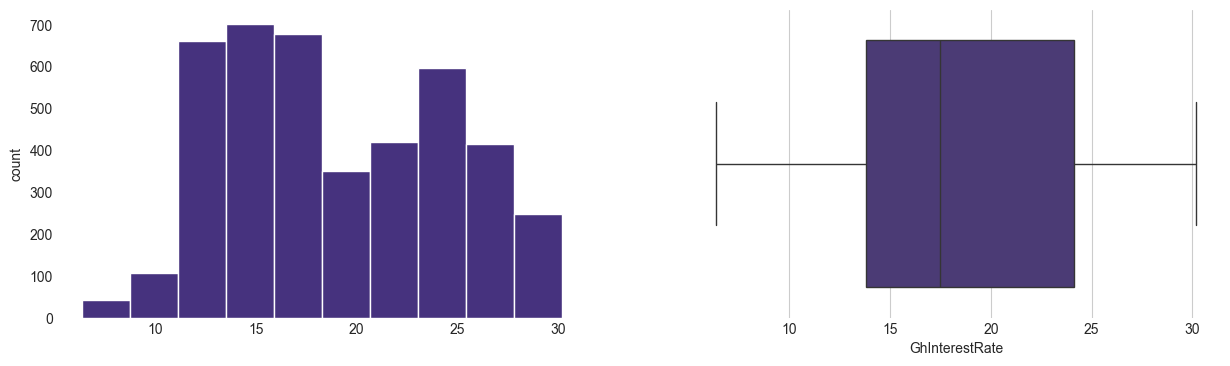

GhGDP
Skew : -0.04


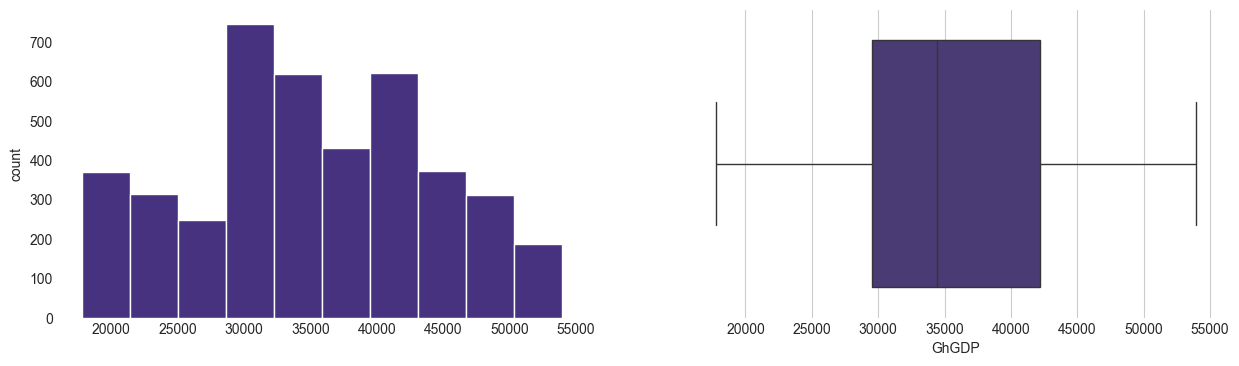

USGDP
Skew : 0.31


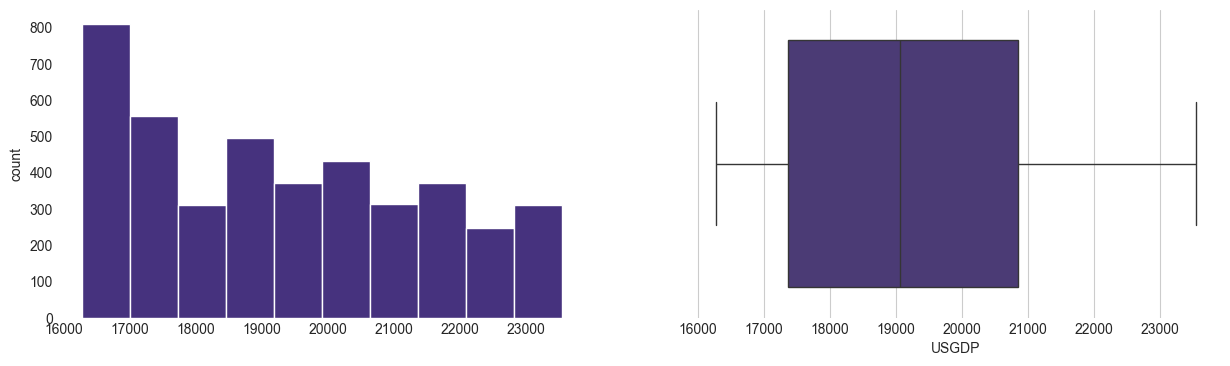

USInflationRate
Skew : 0.74


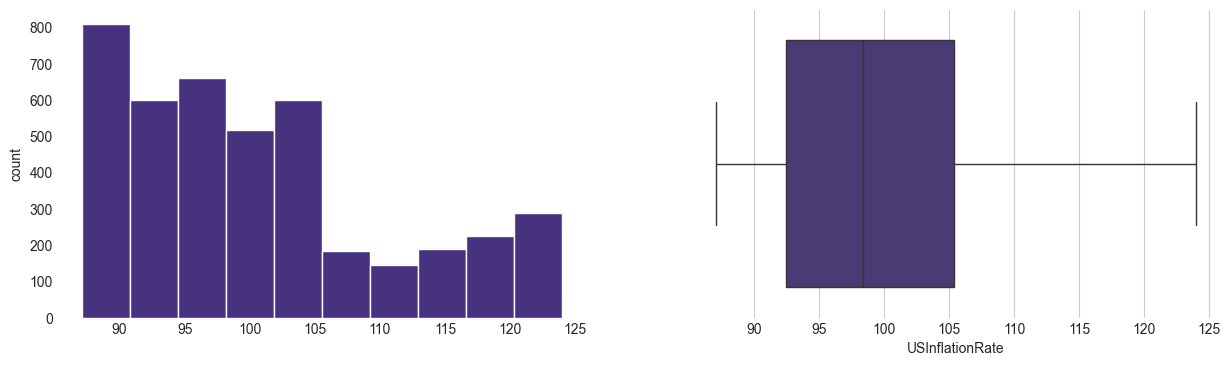

USInterestRate
Skew : 1.48


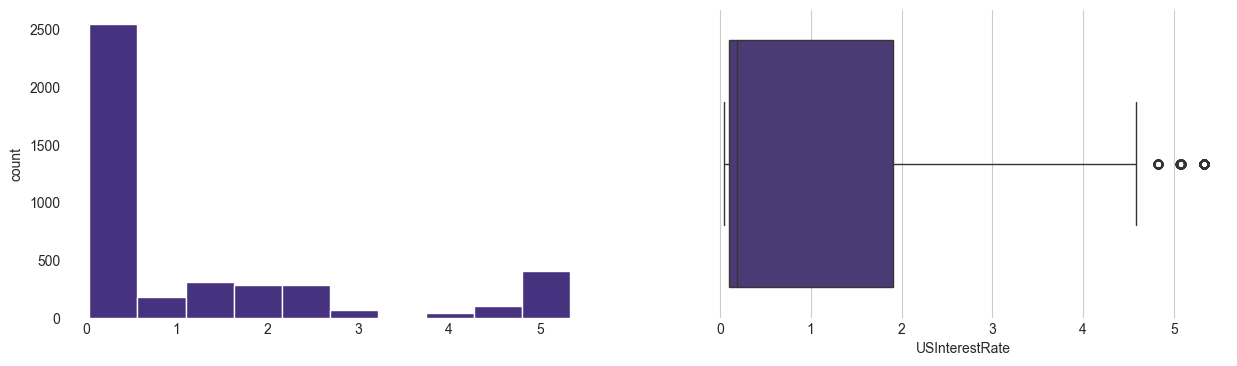

In [64]:
for col in df.columns:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

In [66]:
correlation_matrix = df.corr()

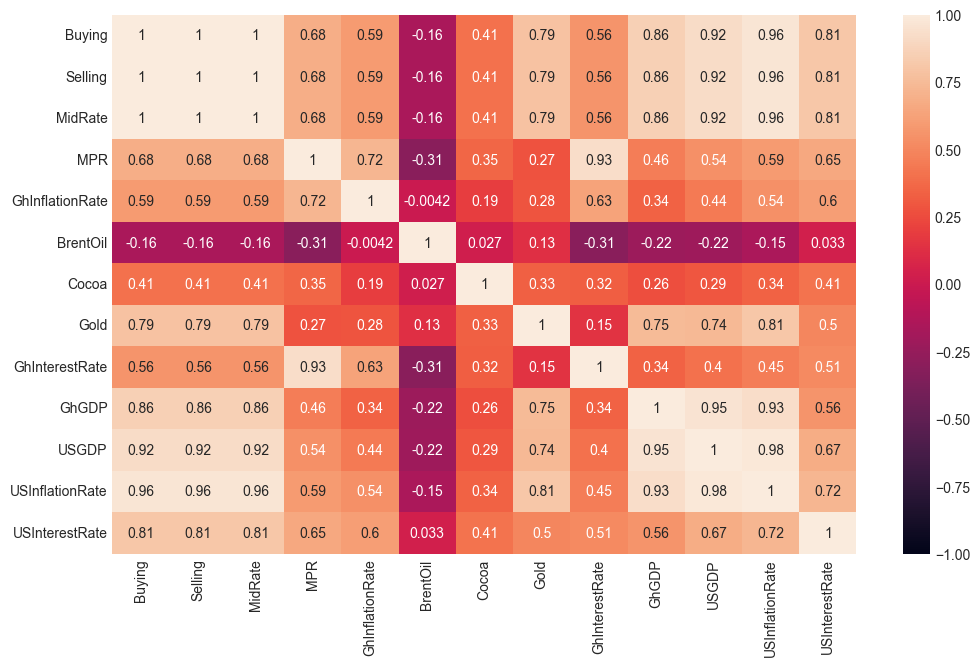

In [77]:
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1)
plt.savefig('plots/correlation_matrix.png')
plt.show()

In [78]:
print(correlation_matrix['Buying'].sort_values(ascending=False))

Buying             1.000000
MidRate            0.999999
Selling            0.999995
USInflationRate    0.963458
USGDP              0.920332
GhGDP              0.856276
USInterestRate     0.805386
Gold               0.786830
MPR                0.682311
GhInflationRate    0.593068
GhInterestRate     0.557285
Cocoa              0.405011
BrentOil          -0.161347
Name: Buying, dtype: float64


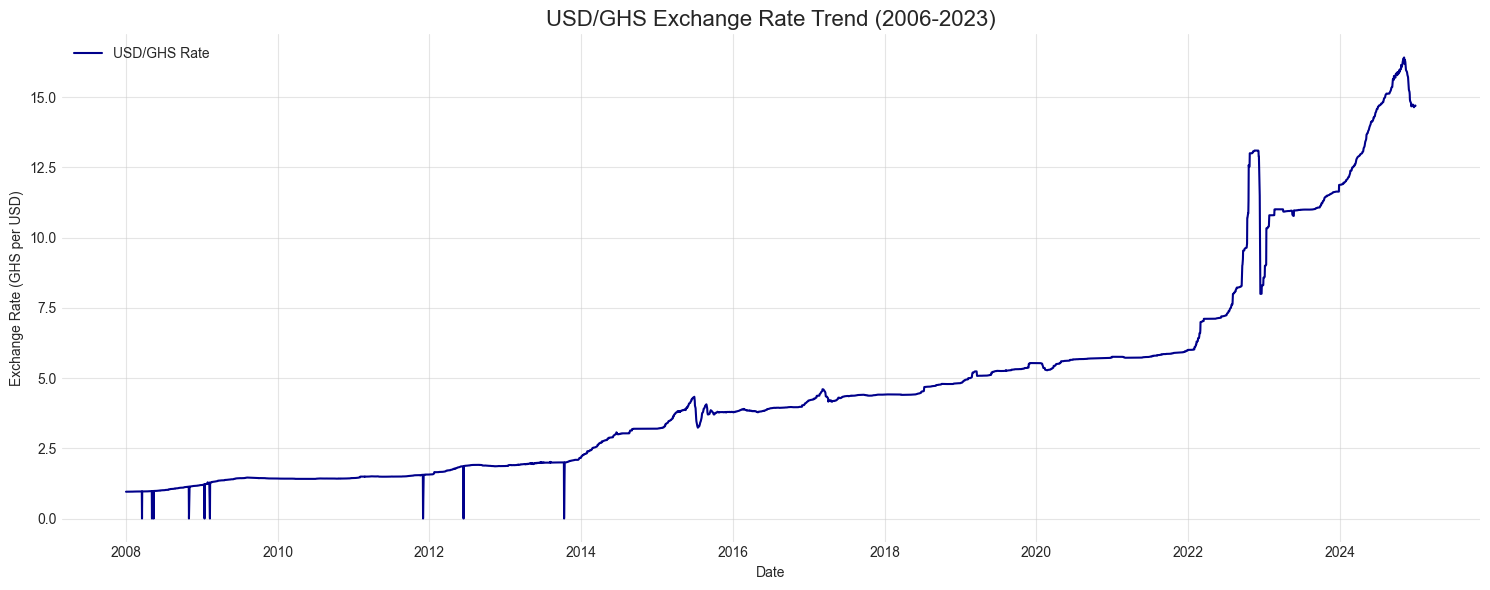

In [79]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Buying'],
         label='USD/GHS Rate', color='darkblue')
plt.title('USD/GHS Exchange Rate Trend (2006-2023)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (GHS per USD)')
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


def perform_multicollinearity_check(file_path):
    """
    Performs a comprehensive multicollinearity check on the FX dataset predictors
    using Variance Inflation Factor (VIF) and a correlation heatmap.

    Args:
        file_path (str): The path to the merged_fx_dataset.csv file.
    """
    print("--- Starting Multicollinearity Check ---")

    # --- 1. Data Loading and Preparation ---
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path.")
        return

    # Convert 'Date' to datetime and set as index for time-series handling
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').set_index('Date')

    # Apply ffill (Last Observation Carried Forward) then bfill for imputation
    # This is a standard and safe way to handle missing data in financial time series.
    df_imputed = df.ffill().bfill()

    # Define the set of independent variables (predictors)
    # We exclude the target ('Buying') and its collinear rates ('Selling', 'MidRate')
    predictor_cols = [
        'MPR', 'GhInflationRate', 'BrentOil', 'Cocoa', 'Gold',
        'GhInterestRate', 'GhGDP', 'USGDP', 'USInflationRate', 'USInterestRate'
    ]

    # Filter the DataFrame to include only the columns used for VIF
    X = df_imputed[predictor_cols].copy()

    # Drop any remaining NaNs (should be minimal after ffill/bfill, but safe guard)
    X = X.dropna()

    if X.empty:
        print("Error: Predictor DataFrame is empty after cleaning.")
        return

    # --- 2. VIF Calculation ---

    # VIF requires an intercept (constant) to be added to the predictor matrix
    X_vif = add_constant(X)

    def calculate_vif(df):
        vif_data = pd.DataFrame()
        vif_data["feature"] = df.columns
        # Calculate VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                           for i in range(df.shape[1])]
        # Exclude the 'const' (intercept) row
        vif_data = vif_data[vif_data['feature'] != 'const']
        vif_data = vif_data.sort_values(
            by="VIF", ascending=False).reset_index(drop=True)
        return vif_data

    vif_results = calculate_vif(X_vif)

    print("\n--- Variance Inflation Factor (VIF) Results ---")
    print("VIF > 10 is generally considered high/problematic multicollinearity.")
    print("-" * 50)
    print(vif_results.to_markdown(index=False))
    print("-" * 50)

    # --- 3. Correlation Heatmap Visualization ---

    # Include the target ('Buying') for the heatmap to visualize all relationships
    cols_for_corr = ['Buying'] + predictor_cols
    df_corr = df_imputed[cols_for_corr]

    # Calculate the correlation matrix
    correlation_matrix = df_corr.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Create a mask for the upper triangle (to make the plot cleaner)
    mask = np.triu(correlation_matrix)

    # Draw the heatmap
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',  # Use 'coolwarm' for clear positive/negative differentiation
        cbar=True,
        linewidths=.5,
        linecolor='black',
        annot_kws={"size": 8}
    )

    plt.title(
        'Correlation Matrix of Predictors and Target (Buying Price)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot
    heatmap_filename = 'correlation_heatmap.png'
    plt.savefig(heatmap_filename)
    plt.show()
    print(
        f"\nSuccessfully generated and saved correlation heatmap as '{heatmap_filename}'")
    plt.close()  # Close the plot to free memory

--- Starting Multicollinearity Check ---

--- Variance Inflation Factor (VIF) Results ---
VIF > 10 is generally considered high/problematic multicollinearity.
--------------------------------------------------
| feature         |       VIF |
|:----------------|----------:|
| USInflationRate | 112.394   |
| USGDP           |  79.6427  |
| GhGDP           |  14.6437  |
| MPR             |  13.9683  |
| GhInterestRate  |   9.48809 |
| Gold            |   8.00443 |
| GhInflationRate |   4.15377 |
| USInterestRate  |   3.54521 |
| BrentOil        |   1.75326 |
| Cocoa           |   1.38149 |
--------------------------------------------------


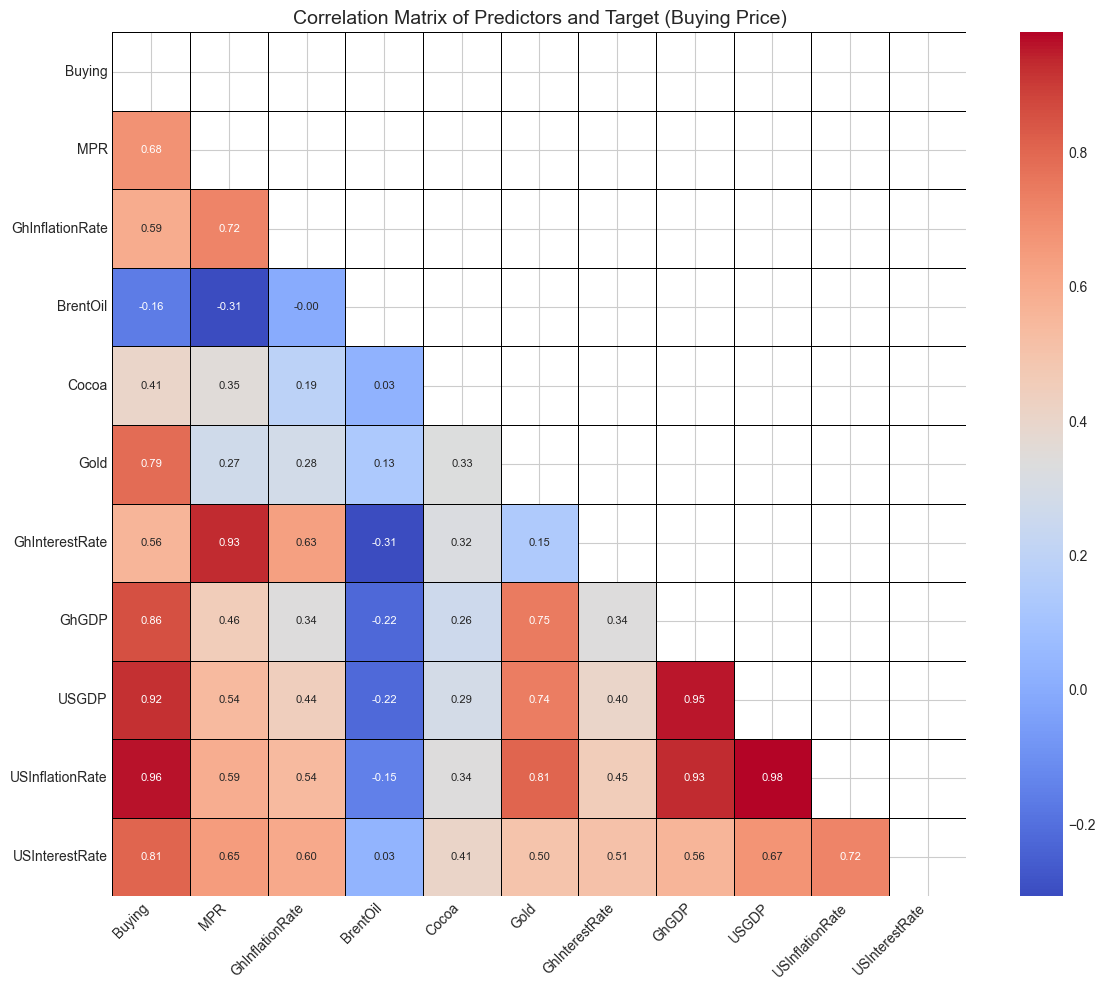


Successfully generated and saved correlation heatmap as 'correlation_heatmap.png'


In [ ]:
perform_multicollinearity_check("datasets/cleaned/merged_fx_dataset.csv")

In [81]:
LAG_DAYS = [1, 7, 30]
ROLLING_WINDOWS = [7, 30, 90]
RSI_PERIOD = 14
BB_WINDOW = 20
BB_STD = 2

In [82]:
def calculate_rsi(series, period):
    """Calculates the Relative Strength Index (RSI) for a given series."""
    diff = series.diff().dropna()
    gain = diff.clip(lower=0)
    loss = -diff.clip(upper=0)

    # Exponentially Weighted Moving Average (EWM) for gain and loss
    avg_gain = gain.ewm(com=period - 1, adjust=False).mean()
    avg_loss = loss.ewm(com=period - 1, adjust=False).mean()

    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Fill initial NaNs with 50 (neutral), then forward-fill
    return rsi.fillna(50).ffill()

In [83]:
def create_features(df_imputed):
    """
    Applies comprehensive feature engineering to the FX rate dataset.

    Args:
        df_imputed (pd.DataFrame): The pre-loaded, sorted, and *initially imputed* DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with all new features added.
    """
    df_feat = df_imputed.copy()

    # --- TEMPORARY: Load Raw Data for Accurate Periodic Change Calculation ---
    # This ensures QoQ and MoM changes only occur on the date the data was released.
    try:
        df_raw = pd.read_csv(FILE_PATH)
        df_raw['Date'] = pd.to_datetime(df_raw['Date'])
        df_raw = df_raw.sort_values(by='Date').set_index('Date')
    except Exception as e:
        print(f"Could not load raw data for ROC calculation: {e}")
        return df_feat # Return imputed frame without ROCs if raw data fails

    # 1. TEMPORAL FEATURES & CYCLICAL ENCODING

    # Simple Temporal Features
    df_feat['DayOfWeek'] = df_feat.index.dayofweek
    df_feat['DayOfYear'] = df_feat.index.dayofyear
    df_feat['Month'] = df_feat.index.month
    df_feat['Quarter'] = df_feat.index.quarter
    df_feat['Year'] = df_feat.index.year

    # Cyclical Encoding (Sine/Cosine for periodic features like Month and Day of Year)
    days_in_year = 366
    df_feat['Month_sin'] = np.sin(2 * np.pi * df_feat['Month'] / 12)
    df_feat['Month_cos'] = np.cos(2 * np.pi * df_feat['Month'] / 12)
    df_feat['DayOfYear_sin'] = np.sin(2 * np.pi * df_feat['DayOfYear'] / days_in_year)
    df_feat['DayOfYear_cos'] = np.cos(2 * np.pi * df_feat['DayOfYear'] / days_in_year)

    # Drop original features after encoding
    df_feat = df_feat.drop(['Month', 'DayOfYear'], axis=1)

    # 2. LAG FEATURES
    for lag in LAG_DAYS:
        # Lagged Target
        df_feat[f'Buying_Lag_{lag}D'] = df_feat['Buying'].shift(lag)
        # Lagged Predictor (MPR)
        df_feat[f'MPR_Lag_{lag}D'] = df_feat['MPR'].shift(lag)

    # 3. RATE OF CHANGE (ROC) - STRATEGY ADJUSTED FOR REPORTING FREQUENCY

    # A. DAILY/NEAR-DAILY ROC (Commodities, Inflation)
    daily_roc_targets = ['BrentOil', 'Cocoa', 'Gold', 'GhInflationRate', 'USInflationRate', 'USInterestRate']
    for col in daily_roc_targets:
        df_feat[f'{col}_ROC_7D'] = df_feat[col].pct_change(periods=7).replace([np.inf, -np.inf], np.nan)
        df_feat[f'{col}_ROC_30D'] = df_feat[col].pct_change(periods=30).replace([np.inf, -np.inf], np.nan)

    # B. MONTHLY ROC (GhInterestRate)
    # Use 30-day lag on the raw series. The result is then ffilled, meaning the model only registers
    # the change when the new monthly rate is released.
    monthly_targets = ['GhInterestRate']
    for col in monthly_targets:
        roc = df_raw[col].pct_change(periods=30).replace([np.inf, -np.inf], np.nan)
        df_feat[f'{col}_ROC_30D_MoM'] = roc.ffill().bfill()

    # C. QUARTERLY ROC (GDP)
    # Use 90-day lag on the raw series for Quarter-over-Quarter (QoQ) change.
    quarterly_targets = ['GhGDP', 'USGDP']
    for col in quarterly_targets:
        roc = df_raw[col].pct_change(periods=90).replace([np.inf, -np.inf], np.nan)
        df_feat[f'{col}_ROC_90D_QoQ'] = roc.ffill().bfill()


    # 4. ROLLING STATISTICS
    for window in ROLLING_WINDOWS:
        # Moving Averages (Trend)
        df_feat[f'Buying_MA_{window}D'] = df_feat['Buying'].rolling(window=window).mean()
        # Volatility (Standard Deviation)
        df_feat[f'Buying_Vol_{window}D'] = df_feat['Buying'].rolling(window=window).std()

    # 5. INTERACTION FEATURES
    df_feat['InterestRateDifferential'] = df_feat['GhInterestRate'] - df_feat['USInterestRate']

    # 6. TECHNICAL INDICATORS
    # Relative Strength Index (RSI)
    df_feat[f'RSI_{RSI_PERIOD}'] = calculate_rsi(df_feat['Buying'], RSI_PERIOD)

    # Bollinger Bands (BB)
    df_feat[f'BB_MA_{BB_WINDOW}D'] = df_feat['Buying'].rolling(window=BB_WINDOW).mean()
    df_feat[f'BB_STD_{BB_WINDOW}D'] = df_feat['Buying'].rolling(window=BB_WINDOW).std()

    df_feat[f'BB_Upper'] = df_feat[f'BB_MA_{BB_WINDOW}D'] + (df_feat[f'BB_STD_{BB_WINDOW}D'] * BB_STD)
    df_feat[f'BB_Lower'] = df_feat[f'BB_MA_{BB_WINDOW}D'] - (df_feat[f'BB_STD_{BB_WINDOW}D'] * BB_STD)

    # --- 7. Final Cleaning and Imputation ---
    # Drop rows where the target or original features are still missing (should be zero after initial ffill/bfill)
    df_feat = df_feat.dropna(subset=df_imputed.columns)

    # Ffill for new features (especially the ROCs created from raw data)
    df_feat = df_feat.ffill()

    # Drop all remaining rows with NaNs. This removes the initial block of rows lost due to
    # the largest window (e.g., 90-day MA) and long lags.
    df_feat = df_feat.dropna()

    return df_feat